# Data Drift Detection
## Preprocessing

In [146]:
import pandas as pd
import numpy as np

original = pd.read_csv('final-weather-flight-data/dataset_YUL-Flights-Weather.csv')
new = pd.read_csv('final-weather-flight-data/Enterprise-II-YUL-Flights-Weather.csv')
#original = original.drop_duplicates()
#original.to_csv('final-weather-flight-data/dataset_YUL-Flights-Weather.csv', index=False)

['Actual Departure Time','Actual Departure'
 'Arrival Terminal', 
 'Departure Delay (min)','Delay (in Minutes)'
    'Departure IATA Code', 'Departure Airport',
    'Estimated Arrival Time',
    'Estimated Departure Time', 
    'IATA Flight Number',
       'Scheduled Arrival Time', 
       'Scheduled Departure Time', 'Scheduled Departure'
       'Status', 'Flight Status',
        'Type']

In [82]:
# time range for old data
print("Time range for original data:")
print(original['Scheduled Departure Time'].min())
print(original['Scheduled Departure Time'].max())

# time range for new data
print("Time range for new data:")
print(new['Scheduled Departure'].min())
print(new['Scheduled Departure'].max())

Time range for original data:
2023-09-30 20:00:00
2024-02-01 18:00:00
Time range for new data:
2024-01-24 06:00:00
2024-04-22 23:00:00


In [85]:
# slice the new data to match the time range of the old data
new = new[(new['Scheduled Departure'] > original['Scheduled Departure Time'].max()) ]

In [147]:
from fuzzywuzzy import fuzz
to_be_droped = ['Type', 'Departure IATA Code',  'Estimated Departure Time', 
    'Actual Departure Time', 'Arrival Terminal', 'Scheduled Arrival Time', 'Estimated Arrival Time', 'Flight Number',
    'IATA Flight Number', 'Timestamp', 'Weather Description']

def detect_column_changes(original, new):
    # Drop columns in the new dataset that are in the to_be_droped list, if any
    new = new.drop(columns=to_be_droped, errors='ignore')
    original = original.drop(columns=to_be_droped)
    # Detect columns in original but not in new
    missing_in_new = original.columns.difference(new.columns)
    if len(missing_in_new) > 0:
        print("Columns missing in new dataset:", missing_in_new)
    
    # Detect columns in new but not in original
    new_in_new = new.columns.difference(original.columns)
    if len(new_in_new) > 0:
        print("Unknown columns in new dataset:", new_in_new)
    
    # Fuzzy matching for similar column names
    for new_col in new_in_new:
        for old_col in original.columns:
            # Check for a high degree of similarity
            if fuzz.token_sort_ratio(new_col, old_col) > 85:
                print(f"New dataset contains column called '{new_col}' which may refer to '{old_col}'.")
                response = input("Do you want to replace that? (yes/no) ")
                if response.lower() == 'yes':
                    new.rename(columns={new_col: old_col}, inplace=True)
                    print(f"Column '{new_col}' has been renamed to '{old_col}'.")
                break
    return new

# Example usage
new = detect_column_changes(original, new)

Columns missing in new dataset: Index(['Departure Delay (min)', 'Scheduled Departure Time', 'Status'], dtype='object')
Unknown columns in new dataset: Index(['Actual Departure', 'Delay (in Minutes)', 'Departure Airport',
       'Flight Status', 'Scheduled Departure'],
      dtype='object')
New dataset contains column called 'Scheduled Departure' which may refer to 'Scheduled Departure Time'.
Column 'Scheduled Departure' has been renamed to 'Scheduled Departure Time'.


In [148]:
# rename columns
new.rename(columns={'Delay (in Minutes)': 'Departure Delay (min)', 'Flight Status': 'Status'}, inplace=True)

In [149]:
new.drop(columns=['Actual Departure', 'Departure Airport'], inplace=True)

In [150]:
to_be_droped = ['Type', 'Departure IATA Code',  'Estimated Departure Time', 
    'Actual Departure Time', 'Arrival Terminal', 'Scheduled Arrival Time', 'Estimated Arrival Time', 'Flight Number',
    'IATA Flight Number', 'Timestamp', 'Weather Description']

original = original.drop(columns=to_be_droped)

# merge the two datasets
merged = pd.concat([original, new], ignore_index=True)
merged.to_csv('final-weather-flight-data/full_dataset_YUL-Flights-Weather.csv', index=False)

In [76]:
# # check for duplicates between the two datasets
# to_be_droped = ['Type', 'Departure IATA Code',  'Estimated Departure Time', 
#     'Actual Departure Time', 'Arrival Terminal', 'Scheduled Arrival Time', 'Estimated Arrival Time', 'Flight Number',
#     'IATA Flight Number', 'Timestamp', 'Weather Description']

# original = original.drop(columns=to_be_droped)
# combined = pd.concat([original, new])

# # Find duplicate rows across the two datasets
# duplicates = combined.duplicated(keep=False)

# # Extract the duplicate rows
# duplicate_rows = combined[duplicates]

# print("Duplicate rows:")
# print(duplicate_rows)

Duplicate rows:
       Status Departure Gate  Departure Delay (min) Scheduled Departure Time  \
6717   active            NaN                    0.0      2023-10-11 08:00:00   
6718   active            NaN                    0.0      2023-10-11 08:00:00   
9603   active            NaN                   25.0      2024-01-06 08:00:00   
9610   active            NaN                   25.0      2024-01-06 08:00:00   
20954  active            NaN                   21.0      2024-01-23 20:00:00   
21056  active            NaN                   21.0      2024-01-23 20:00:00   
29425  active            NaN                   21.0      2024-01-17 20:00:00   
29645  active            NaN                   21.0      2024-01-17 20:00:00   

      Arrival IATA Code       Airline Name  Temperature  Feels Like  Pressure  \
6717                teb  starlink aviation         8.72        8.72    1009.0   
6718                teb  starlink aviation         8.72        8.72    1009.0   
9603                

In [77]:
# # remove rows that are in duplicate_rows from new
# new = new[~new.isin(duplicate_rows)]


In [90]:
new.to_csv('final-weather-flight-data/Enterprise-II-YUL-Flights-Weather-renamed.csv',index=False)

after preprocessing....

## Model Development

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
ensemble =  VotingRegressor(
        estimators=[
            ('lr', LinearRegression()),
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42)),
            ('xgb', xgb.XGBRegressor(random_state=42)),
            ('svm', SVR())
        ]
    )

after = pd.read_csv('./final-weather-flight-data/Enterprise-II-processed_dataset_YUL-Flights-Weather.csv')
X_after = after.drop(columns=['Departure Delay (min)'])
y_after = after['Departure Delay (min)']
X_train, X_test, y_train, y_test = train_test_split(X_after, y_after, test_size=0.2, random_state=42)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
print(mean_squared_error(y_test, y_pred))

1.4595597520345105


In [92]:
before = pd.read_csv('final-weather-flight-data/processed_dataset_YUL-Flights-Weather.csv')
X_before = before.drop(columns=['Departure Delay (min)'])
y_before = before['Departure Delay (min)']
X_train_before, X_test_before, y_train_before, y_test_before = train_test_split(X_before, y_before, test_size=0.2, random_state=42)

ensemble.fit(X_train_before, y_train_before)
y_pred_before = ensemble.predict(X_test_before)
print(mean_squared_error(y_test_before, y_pred_before))

0.593609718376034


In [102]:
# get feature importance
ensemble.fit(X_after, y_after)
feature_importance = ensemble.named_estimators_['rf'].feature_importances_
feature_importance = pd.DataFrame({'feature': X_after.columns, 'importance': feature_importance}).sort_values(by='importance', ascending=False)
print(feature_importance)

                  feature  importance
9          Departure Gate    0.177999
10      Arrival IATA Code    0.106773
8                 Snow 1h    0.100518
3                Humidity    0.088702
11           Airline Name    0.085754
1              Feels Like    0.079332
2                Pressure    0.066932
5             Wind Degree    0.057484
0             Temperature    0.057279
4              Wind Speed    0.051756
6                  Clouds    0.048308
14   Weekday of Departure    0.037889
13  Departure Time of Day    0.014991
12           Weather Main    0.009902
16                 Season    0.009280
17             Visibility    0.003431
15       Weather Severity    0.002145
7                 Rain 1h    0.001523


We see massive increase on mse, so the model performance gone bad.

## TFDV

In [93]:
import tensorflow as tf
import tensorflow_data_validation as tfdv
import pandas as pd

early_data_stats = tfdv.generate_statistics_from_dataframe(before)

latest_data_stats = tfdv.generate_statistics_from_dataframe(after)
# visualize statistics
tfdv.visualize_statistics(early_data_stats)

In [94]:
html = tfdv.get_statistics_html(early_data_stats)
with open('data-drift-viz/early_data_stats.html', 'w') as f:
    f.write(html)

In [53]:
tfdv.visualize_statistics(latest_data_stats)

In [95]:
html = tfdv.get_statistics_html(latest_data_stats)
with open('data-drift-viz/latest_data_stats.html', 'w') as f:
    f.write(html)

In [96]:
# infer schema from the statistics 
early_data_schema = tfdv.infer_schema(statistics=early_data_stats)
# display the schema
tfdv.display_schema(schema=early_data_schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Departure Delay (min)',FLOAT,required,,-
'Temperature',FLOAT,required,,-
'Feels Like',FLOAT,required,,-
'Pressure',FLOAT,required,,-
'Humidity',FLOAT,required,,-
'Wind Speed',FLOAT,required,,-
'Wind Degree',FLOAT,required,,-
'Clouds',FLOAT,required,,-
'Rain 1h',FLOAT,required,,-


In [97]:
anomalies_schema = tfdv.validate_statistics(statistics=latest_data_stats, schema=early_data_schema)
tfdv.display_anomalies(anomalies_schema)

In [98]:
tfdv.visualize_statistics(lhs_statistics=early_data_stats, rhs_statistics=latest_data_stats,
                          lhs_name='before feb', rhs_name='after feb')

In [100]:
# write to html
html = tfdv.get_statistics_html(lhs_statistics=early_data_stats, rhs_statistics=latest_data_stats,
                          lhs_name='before feb', rhs_name='after feb')
with open('data-drift-viz/stacked_view.html', 'w') as f:
    f.write(html)



As a general rule of thumb, some suggested threshold values for monitoring feature drift using JSD are:

- Small threshold value (e.g., 0.05 to 0.1): This threshold value may be appropriate when detecting subtle changes in patterns, or when the consequences of feature drift are severe (e.g., in fraud detection or medical diagnosis applications).
- Medium threshold value (e.g., 0.1 to 0.2): This threshold value may be appropriate when detecting moderate changes in patterns, or when the consequences of feature drift are less severe (e.g., in recommendation systems or marketing campaigns).
- Large threshold value (e.g., > 0.2): This threshold value may be appropriate when detecting major changes in patterns, or when the consequences of feature drift are relatively minor (e.g., in product quality monitoring or website traffic analysis).

On the other hand, the L-infinity norm is a metric used to quantify the difference between the probability distributions of two categorical variables. Specifically, it measures the maximum absolute difference between the probability values of corresponding categories in the two distributions. The same guidelines mentioned earlier are also applicable here.

In [103]:


# Feature importance as provided
feature_importance = {
    'Departure Gate': 0.177999, 'Arrival IATA Code': 0.106773, 'Snow 1h': 0.100518,
    'Humidity': 0.088702, 'Airline Name': 0.085754, 'Feels Like': 0.079332,
    'Pressure': 0.066932, 'Wind Degree': 0.057484, 'Temperature': 0.057279,
    'Wind Speed': 0.051756, 'Clouds': 0.048308, 'Weekday of Departure': 0.037889,
    'Departure Time of Day': 0.014991, 'Weather Main': 0.009902, 'Season': 0.009280,
    'Visibility': 0.003431, 'Weather Severity': 0.002145, 'Rain 1h': 0.001523
}

# Scale the importance to [0.01, 0.2] for drift thresholds
min_threshold, max_threshold = 0.01, 0.2
scale = max_threshold - min_threshold
normalized_thresholds = {k: max_threshold - v / max(feature_importance.values()) * scale for k, v in feature_importance.items()}

# Configure drift detection for each feature in the schema
for feature in early_data_schema.feature:
    if feature.name in normalized_thresholds:
        # Set the Jensen-Shannon divergence as the drift metric
        feature.drift_comparator.jensen_shannon_divergence.threshold = normalized_thresholds[feature.name]

# Validate the latest dataset against the schema
anomalies = tfdv.validate_statistics(statistics=latest_data_stats, schema=early_data_schema)

# Display the anomalies detected (includes drift based on the comparator)
tfdv.display_anomalies(anomalies)

In [104]:
normalized_thresholds

{'Departure Gate': 0.010000000000000009,
 'Arrival IATA Code': 0.08602817993359513,
 'Snow 1h': 0.0927049028365328,
 'Humidity': 0.10531755796380879,
 'Airline Name': 0.10846431721526527,
 'Feels Like': 0.11531929954662667,
 'Pressure': 0.12855532896252225,
 'Wind Degree': 0.13864032944005303,
 'Temperature': 0.13885915089410616,
 'Wind Speed': 0.1447545210928151,
 'Clouds': 0.14843499120781578,
 'Weekday of Departure': 0.15955645818234934,
 'Departure Time of Day': 0.1839982808892185,
 'Weather Main': 0.18943039005837112,
 'Season': 0.19009432637262008,
 'Visibility': 0.19633767605435987,
 'Weather Severity': 0.19771038039539549,
 'Rain 1h': 0.19837431670964445}

### Training-Serving Skew Detection with TFDV

In [112]:
feature_name = ['Snow 1h','Departure Gate', 'Arrival IATA Code', 'Arrival IATA Code', 'Airline Name']

for feature in feature_name:
    feature_in_schema = tfdv.get_feature(early_data_schema, feature)
    if feature_in_schema:  # Check if the feature exists in the schema
        feature_in_schema.skew_comparator.infinity_norm.threshold = 0.01

# Validate the serving statistics against the training schema to detect skew
skew_anomalies = tfdv.validate_statistics(statistics=latest_data_stats, schema=early_data_schema, serving_statistics=early_data_stats)

# Display the detected anomalies
tfdv.display_anomalies(skew_anomalies)

In [113]:
for feature in feature_name:
    feature_in_schema = tfdv.get_feature(early_data_schema, feature)
    if feature_in_schema:  # Check if the feature exists in the schema
        feature_in_schema.drift_comparator.infinity_norm.threshold = 0.01

drift_anomalies = tfdv.validate_statistics(statistics=latest_data_stats, schema=early_data_schema, serving_statistics=early_data_stats)

# Display the detected anomalies
tfdv.display_anomalies(drift_anomalies)

## Model based Drift Detection with Alibi-Detect

In [227]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from alibi_detect.cd import ClassifierDrift

# Assuming each sample has 10 features (change this as per your actual feature count)
feature_count = X_before.shape[1]

# Use a very simple model
model = Sequential([
    Input(shape=(feature_count,)),
    Dense(10, activation='relu'),  # Reduced complexity further
    Dense(2, activation='softmax')
])
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy')  # Increased learning rate for quicker convergence

cd = ClassifierDrift(
    threshold=0.55,
    model=model,
    X_ref=X_before,
    n_folds=1,  # Minimal cross-validation
    epochs=1,
    batch_size=64  # Increased batch size for speed
)

# Perform drift detection, outputting only the drift metric for speed
preds_drift = cd.predict(X_after, return_metric=True)
print("Drift Metric:", preds_drift['data']['metric'])


In [ ]:
model.save('data-drift-viz/Classifier_Drift.h5')


## Manual
### Lable Drift


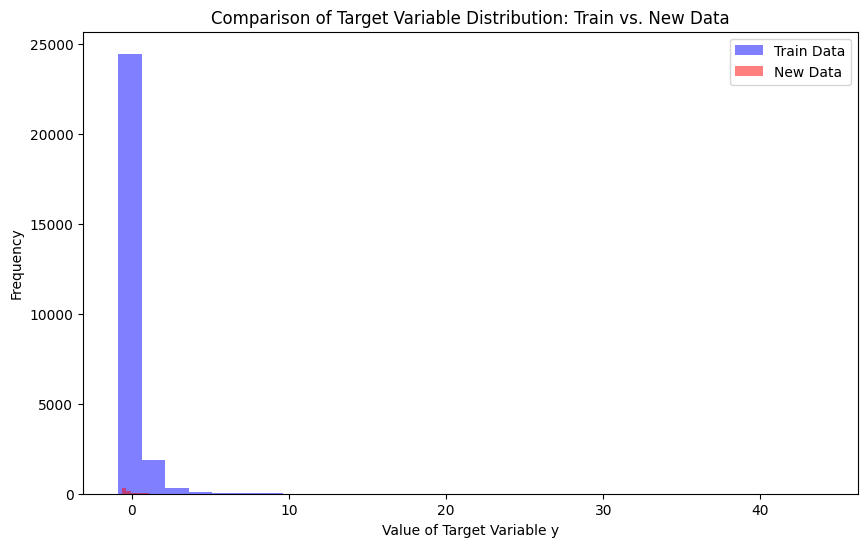

K-S Statistic: 0.2675097172295119, P-value: 3.187356862561735e-39
There is significant label drift between training and new data.


In [114]:
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
# Visualize the distributions of 'y'
plt.figure(figsize=(10, 6))
plt.hist(y_before, bins=30, alpha=0.5, label='Train Data', color='blue')
plt.hist(y_after, bins=30, alpha=0.5, label='New Data', color='red')
plt.title('Comparison of Target Variable Distribution: Train vs. New Data')
plt.xlabel('Value of Target Variable y')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Perform a statistical test for distribution comparison
stat, p_value = ks_2samp(y_before, y_after)
print(f"K-S Statistic: {stat}, P-value: {p_value}")

# Interpret the result
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is significant label drift between training and new data.")
else:
    print("No significant label drift detected.")

In [142]:
# Initialize lists to store features that exhibit drift for each test
kl_drifted_features = []
js_drifted_features = []
ks_drifted_features = []
linf_drifted_features = []

# Define thresholds for detecting drift
kl_threshold = 0.2
js_threshold = 0.2
ks_threshold = 0.2  # p-value threshold for KS test
linf_threshold = 0.2

# Define the number of bins for the histogram
num_bins = 100

# Loop through each feature to calculate drift metrics
for feature in before.columns:
    before_feature = before[feature].values
    after_feature = after[feature].values

    # Calculate histograms and bin edges for the two distributions
    bin_edges = np.histogram_bin_edges(np.concatenate((before_feature, after_feature)), bins=num_bins)
    before_hist, _ = np.histogram(before_feature, bins=bin_edges, density=False)
    after_hist, _ = np.histogram(after_feature, bins=bin_edges, density=False)

    # Normalize the histograms to reflect percentages
    before_hist = before_hist / np.sum(before_hist)
    after_hist = after_hist / np.sum(after_hist)

    # Calculate drift metrics
    kl_div = entropy(before_hist, after_hist)
    js_div = jensenshannon(before_hist, after_hist)
    ks_stat, ks_pval = ks_2samp(before_feature, after_feature)
    linf_dist = np.max(np.abs(before_hist - after_hist))

    # Check against thresholds and record features that show drift
    if kl_div > kl_threshold:
        kl_drifted_features.append(feature)
    if js_div > js_threshold:
        js_drifted_features.append(feature)
    if ks_pval < ks_threshold:
        ks_drifted_features.append(feature)
    if linf_dist > linf_threshold:
        linf_drifted_features.append(feature)

# Print the features that drifted based on each metric
print("KL Drifted Features:", kl_drifted_features)
print("JS Drifted Features:", js_drifted_features)
print("KS Drifted Features:", ks_drifted_features)
print("L-infinity Drifted Features:", linf_drifted_features)

KL Drifted Features: ['Departure Delay (min)', 'Temperature', 'Feels Like', 'Pressure', 'Humidity', 'Wind Speed', 'Wind Degree', 'Clouds', 'Rain 1h', 'Snow 1h', 'Departure Gate', 'Arrival IATA Code', 'Airline Name', 'Weather Main']
JS Drifted Features: ['Temperature', 'Feels Like', 'Pressure', 'Humidity', 'Wind Speed', 'Wind Degree', 'Clouds', 'Departure Gate', 'Arrival IATA Code', 'Airline Name']
KS Drifted Features: ['Departure Delay (min)', 'Temperature', 'Feels Like', 'Pressure', 'Humidity', 'Wind Speed', 'Wind Degree', 'Clouds', 'Rain 1h', 'Snow 1h', 'Departure Gate', 'Arrival IATA Code', 'Airline Name', 'Weather Main', 'Departure Time of Day', 'Weekday of Departure', 'Weather Severity', 'Season', 'Visibility']
L-infinity Drifted Features: ['Clouds', 'Departure Gate', 'Arrival IATA Code', 'Airline Name']


after this test and compare manually with distributions, we believe L-infinity Drifted Features are rather useful.

## Solutions

In [166]:

ensemble.fit(X_before, y_before)
y_pred_before = ensemble.predict(X_after)
print(mean_squared_error(y_after, y_pred_before))

1.0271840439168292


In [167]:
from sklearn.metrics import mean_squared_error, r2_score
print("R2 Score:", r2_score(y_after, y_pred_before))

R2 Score: -0.027184043916828937


In [204]:
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
original = pd.read_csv('final-weather-flight-data/dataset_YUL-Flights-Weather.csv')
new = pd.read_csv('final-weather-flight-data/Enterprise-II-YUL-Flights-Weather-renamed.csv')
to_be_droped = ['Type', 'Departure IATA Code',  'Estimated Departure Time', 
    'Actual Departure Time', 'Arrival Terminal', 'Scheduled Arrival Time', 'Estimated Arrival Time', 'Flight Number',
    'IATA Flight Number', 'Timestamp', 'Weather Description']

original = original.drop(columns=to_be_droped)

df = original.copy()
def custom_preprocess_data(df):
    # Convert Scheduled Departure Time and Estimated Departure Time to datetime
    df['Scheduled Departure Time'] = pd.to_datetime(df['Scheduled Departure Time'])
    #df['Estimated Departure Time'] = pd.to_datetime(df['Estimated Departure Time'])
    
    # Calculate the difference in minutes
    # df['Estimated Departure Delay (min)'] = (df['Estimated Departure Time'] - df['Scheduled Departure Time']).dt.total_seconds() / 60

    # Calculate the time of day
    df['Departure Time of Day'] = pd.cut(df['Scheduled Departure Time'].dt.hour, 
                                     bins=[0, 6, 12, 18, 24], 
                                     labels=['Night', 'Morning', 'Afternoon', 'Evening'], 
                                     right=False)

    # Weekday of departure
    df['Weekday of Departure'] = df['Scheduled Departure Time'].dt.day_name()

    # Calculate weather severety
    df['Weather Severity'] = np.where((df['Rain 1h'] > 0) | (df['Snow 1h'] > 0), 'Bad', 'Good')

    # Filter out detinations with a frequency less than 100
    destintaiton_counts = df['Arrival IATA Code'].value_counts()
    destinations_to_keep = destintaiton_counts[destintaiton_counts >= 100].index
    df = df[df['Arrival IATA Code'].isin(destinations_to_keep)]

    # Filter out infrequent airlines
    # airline_counts = df['Airline Name'].value_counts()
    # airlines_to_keep = airline_counts[airline_counts >= 50].index
    # df = df[df['Airline Name'].isin(airlines_to_keep)]

    # Feature engineering: Create a feature for delay status
    # df['Delay Status'] = pd.cut(df['Departure Delay (min)'], 
    #                             bins=[-np.inf, 0, 15, 60, np.inf], 
    #                             labels=['On Time', 'Slight Delay', 'Moderate Delay', 'Severe Delay'])

    # Feature engineering: Create a feature for season based on month
    df['Season'] = pd.cut(df['Scheduled Departure Time'].dt.month, 
                          bins=[0, 3, 6, 9, 12], 
                          labels=['Winter', 'Spring', 'Summer', 'Fall'], 
                          right=False)

    # Feature engineering: Create a binary feature for weekend departure
    df['Weekend Departure'] = df['Weekday of Departure'].isin(['Saturday', 'Sunday']).astype(int)

    # Feature engineering: Create a feature for visibility based on weather conditions
    df['Visibility'] = np.where((df['Weather Main'].isin(['Fog', 'Mist', 'Haze', 'Snow', 'Rain'])), 'Low', 'High')

    # # Convert Scheduled Arrival Time and Scheduled Departure Time to datetime before calculating duration
    # df['Scheduled Arrival Time'] = pd.to_datetime(df['Scheduled Arrival Time'])
    # df['Scheduled Departure Time'] = pd.to_datetime(df['Scheduled Departure Time'])
    # df['Flight Duration (min)'] = (df['Scheduled Arrival Time'] - df['Scheduled Departure Time']).dt.total_seconds() / 60

    # Drop unwanted columns
    # df = df.drop(columns=['Type', 'Departure IATA Code', 'Scheduled Departure Time', 'Estimated Departure Time', 
    # 'Actual Departure Time', 'Arrival Terminal', 'Scheduled Arrival Time', 'Estimated Arrival Time', 'Flight Number',
    # 'IATA Flight Number', 'Timestamp', 'Weather Description'])
    
    # Filter rows where 'Status' is not 'active'
    df = df[df['Status'] == 'active']
    
    # Drop the 'Status' column as it's no longer needed
    df = df.drop(columns=['Status'])
    
    return df
df = custom_preprocess_data(df)

categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Define the categorical transformer with an OrdinalEncoder
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Only process categorical data and pass through the rest
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_cols)
], remainder='passthrough')

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Apply the pipeline to the dataset
X_processed = pipeline.fit_transform(df)
feature_names = categorical_cols.tolist() + [col for col in df.columns if col not in categorical_cols]

# Convert the processed data back to a DataFrame and specify the dtype
processed_df = pd.DataFrame(X_processed, columns=feature_names, index=df.index)

#

for col in processed_df.columns:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')

# Optionally, drop the 'Scheduled Departure Time' if no longer needed
processed_df.drop(columns='Scheduled Departure Time', inplace=True)

b4 = processed_df.copy()

C:\Users\PrudenceC\AppData\Local\Temp\ipykernel_27152\804693375.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = pd.cut(df['Scheduled Departure Time'].dt.month,
C:\Users\PrudenceC\AppData\Local\Temp\ipykernel_27152\804693375.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weekend Departure'] = df['Weekday of Departure'].isin(['Saturday', 'Sunday']).astype(int)
C:\Users\PrudenceC\AppData\Local\Temp\ipykernel_27152\804693375.py:63: SettingWithCopyWarning: 
A value is trying to be s

In [184]:
b4.dtypes

Departure Gate           float64
Arrival IATA Code        float64
Airline Name             float64
Weather Main             float64
Departure Time of Day    float64
Weekday of Departure     float64
Weather Severity         float64
Season                   float64
Visibility               float64
Departure Delay (min)      int64
Temperature              float64
Feels Like               float64
Pressure                 float64
Humidity                 float64
Wind Speed               float64
Wind Degree              float64
Clouds                   float64
Rain 1h                  float64
Snow 1h                  float64
Weekend Departure          int64
dtype: object

In [205]:
df = new.copy()
df = custom_preprocess_data(df)
# Apply the pipeline to the dataset
X_processed = pipeline.fit_transform(df)
feature_names = categorical_cols.tolist() + [col for col in df.columns if col not in categorical_cols]

# Convert the processed data back to a DataFrame and specify the dtype
processed_df = pd.DataFrame(X_processed, columns=feature_names, index=df.index)


for col in processed_df.columns:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')

# Optionally, drop the 'Scheduled Departure Time' if no longer needed
processed_df.drop(columns='Scheduled Departure Time', inplace=True)


af = processed_df.copy()

C:\Users\PrudenceC\AppData\Local\Temp\ipykernel_27152\804693375.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = pd.cut(df['Scheduled Departure Time'].dt.month,
C:\Users\PrudenceC\AppData\Local\Temp\ipykernel_27152\804693375.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weekend Departure'] = df['Weekday of Departure'].isin(['Saturday', 'Sunday']).astype(int)
C:\Users\PrudenceC\AppData\Local\Temp\ipykernel_27152\804693375.py:63: SettingWithCopyWarning: 
A value is trying to be s

In [206]:
b4 = b4.dropna()
af = af.dropna()

In [207]:
X1 = b4.drop(columns=['Departure Delay (min)'])
y1 = b4['Departure Delay (min)']
X2 = af.drop(columns=['Departure Delay (min)'])
y2 = af['Departure Delay (min)']

ensemble.fit(X1, y1)
y_pred2 = ensemble.predict(X2)
print(mean_squared_error(y2, y_pred2))

7375.303093465333


In [208]:
# print r^2
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(y2, y_pred2))

-0.017612971667058552


### give more importance to more recent data

In [214]:


# Load your dataset
df = pd.read_csv('final-weather-flight-data/full_dataset_YUL-Flights-Weather.csv')  # Load your dataset
df['Scheduled Departure Time'] = pd.to_datetime(df['Scheduled Departure Time'])
df = custom_preprocess_data(df)
# Apply the pipeline to the dataset
X_processed = pipeline.fit_transform(df)
feature_names = categorical_cols.tolist() + [col for col in df.columns if col not in categorical_cols]

# Convert the processed data back to a DataFrame and specify the dtype
processed_df = pd.DataFrame(X_processed, columns=feature_names, index=df.index)


for col in processed_df.columns.drop('Scheduled Departure Time'):
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
full = processed_df.copy()

C:\Users\PrudenceC\AppData\Local\Temp\ipykernel_27152\804693375.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = pd.cut(df['Scheduled Departure Time'].dt.month,
C:\Users\PrudenceC\AppData\Local\Temp\ipykernel_27152\804693375.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weekend Departure'] = df['Weekday of Departure'].isin(['Saturday', 'Sunday']).astype(int)
C:\Users\PrudenceC\AppData\Local\Temp\ipykernel_27152\804693375.py:63: SettingWithCopyWarning: 
A value is trying to be s

In [222]:

# spilt the data by time
full['Scheduled Departure Time'] = pd.to_datetime(full['Scheduled Departure Time'])
full_train = full[(full['Scheduled Departure Time'] <= original['Scheduled Departure Time'].max()) ]
full_test = full[(full['Scheduled Departure Time'] > original['Scheduled Departure Time'].max()) ]
full_train, full_test = full_train.dropna(), full_test.dropna()
# Shuffle the training data
full_train = shuffle(full_train, random_state=42)

# Sorting by 'Scheduled Departure Time'
full_train.sort_values('Scheduled Departure Time', ascending=True, inplace=True)

# Assign weights that increase linearly toward the most recent data
weights = np.linspace(start=0.1, stop=1.0, num=len(full_train))

# Prepare training features and target variable
full_train_target = full_train['Departure Delay (min)']
full_train_features = full_train.drop(columns=['Departure Delay (min)', 'Scheduled Departure Time'])

# Initialize the regressors
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(random_state=42)
svm = SVR()

# Create the VotingRegressor ensemble
ensemble = VotingRegressor(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('gb', gb),
        ('xgb', xgb_model),
        ('svm', svm)
    ]
)

# Train the model with the assigned weights
ensemble.fit(full_train_features, full_train_target, sample_weight=weights)

# Prepare the test data (similarly to training data)
full_test_target = full_test['Departure Delay (min)']
full_test_features = full_test.drop(columns=['Departure Delay (min)', 'Scheduled Departure Time'])

# Predict using the model
predictions = ensemble.predict(full_test_features)

# Evaluate the model (example using MSE)
mse = mean_squared_error(full_test_target, predictions)
print(f'Mean Squared Error on Test Set: {mse}')
r2 = r2_score(full_test_target, predictions)
print(f'R2 Score on Test Set: {r2}')

Mean Squared Error on Test Set: 7334.08968835703
R2 Score on Test Set: -0.013535160013777636
